<a href="https://colab.research.google.com/github/almiab1/MUIIADeepLearning/blob/main/PracticaFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica Final | Deep Learning

En el presente trabajo se proponen dos modelos basados en redes convolucionales, los cuales se trata de clasificar correctamente si un individuo está parpadeando o no. En la actualidad se pueden encontrar modelos de gran calidad, los cuales permiten construir modelos de gran precisión basándose sobre la base de dichos modelos pre-entrenados. Por ello, los modelos propuestos en este trabajo se definen haciendo uso de modelos previamente entrenados.

En primer lugar, se propone una red basada en el modelo `InceptionResNetV2`. Un modelo pesado de gran profundidad que proporciona buenos resultados en problemas de clasificación. Se propone una estrategia donde el modelo `InceptionResNetV2` toma la función de extractor de características, obteniendo así las características profundas que posteriormente podrán ser utilizadas en la clasificación de las imágenes. En segundo punto, se propone una red basada en el modelo `DenseNet`. Un modelo de menor tamaño y que permite obtener resultados similares a los de `InceptionResNetV2`. En este caso se trata de re-entrenar el clasificador y aplicando `fine tuning` con el fin de ajustar los parámetros del modelo.

Dado que se parte de un conjunto de datos desbalanceado, es necesario aplicar algunos métodos de balanceo con el fin de obtener un modelo más robusto. Previamente, al entrenamiento de la red, se propone el uso de técnicas como la estratificación de datos o `data augmentation`. A su vez, para mejorar el proceso de entrenamiento se hace empleo de `mini-batches` y de optimizadores como el optimizador Adam.

In [80]:
# Data manipulation and linear algebra
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2

# Neural network API
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Keras imports
from tensorflow.keras import optimizers, Input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Concatenate, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.applications import InceptionResNetV2, DenseNet169 
from keras.utils import plot_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install -U tensorflow-addons
from tensorflow_addons.metrics import F1Score

In [81]:
_isColab = False

if _isColab:
    from google.colab import drive

    # Montamos el Google Drive en el directorio del proyecto y descomprimios el fichero con los datos
    drive.mount('/content/drive')
    !unzip -n '/content/drive/MyDrive/UIMP/Asignaturas/5-DeepLearning/Practicas/Final/Source/RT-BENE.zip' >> /dev/null

## Conjunto de datos

Se va a trabajar con un conjunto de imágenes donde se representan los ojos de una persona. Se dispone de un fichero `csv` que define, para cada frame, si este se trata de un parpadeo o no y la ruta a las imágenes de los ojos izquierdo y derecho.

In [82]:
# Especificamos los paths al directorio que contiene las imagenes y al fichero con las etiquetas
data_path = 'RT-BENE/'

if _isColab == False:
    data_path = "./../RT-BENE/"

imgs_path = data_path + "images/"
labels_path = data_path + "blinks.csv"


# Leemos el fichero CSV con las etiquetas
labels = pd.read_csv(labels_path, dtype = {"blink": "category"})

El dataframe `labels` contiene 5 atributos:

- *frame_id*: identificador del fotograma.
- *left_eye*: imagen del ojo izquierdo.
- *right_eye*: imagen del ojo derecho.
- *video*: identificador del video al que pertenece el fotograma.
- *blink*: atributo clase, define si el sujeto está o no parpadeando en el fotograma.

In [83]:
# Mostramos los primero elementos del dataset
labels.head()

,blink_id,left_eye,right_eye,video,blink
0,0,0_left_000001_rgb.png,0_right_000001_rgb.png,0,0
1,1,0_left_000002_rgb.png,0_right_000002_rgb.png,0,0
2,2,0_left_000003_rgb.png,0_right_000003_rgb.png,0,0
3,3,0_left_000004_rgb.png,0_right_000004_rgb.png,0,0
4,4,0_left_000005_rgb.png,0_right_000005_rgb.png,0,0


Con el fin de tener una idea de las imágenes que se tratan, se muestran dos ejemplos:

- Dos imágenes correspondientes al ojo derecho e izquierdo sin parpadear
- Dos imágenes correspondientes al ojo derecho e izquierdo parpadeando

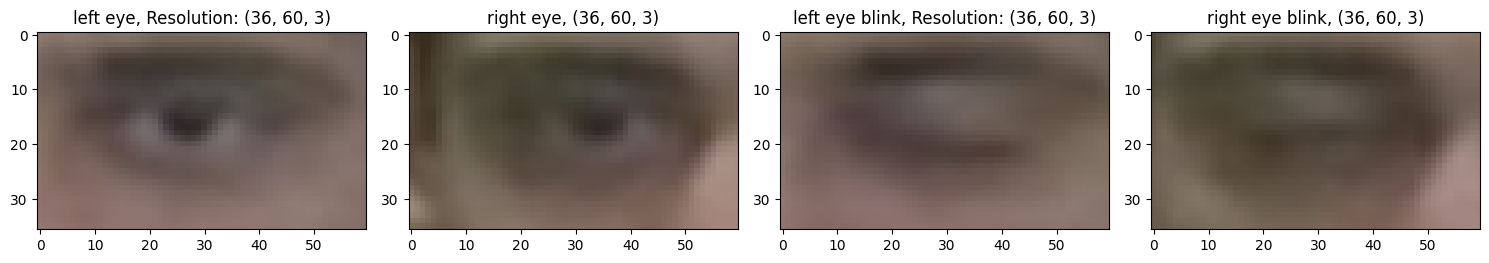

In [84]:
fig, ax = plt.subplots(1,4, figsize=(15,8))
# Cataract Image
left_eye_1 = mpimage.imread(f'{imgs_path}/0_left_000001_rgb.png')
ax[0].imshow(left_eye_1)
ax[0].set_title(f'left eye, Resolution: {left_eye_1.shape}')

# Diabetic_retinopathy
right_eye_1 = mpimage.imread(f'{imgs_path}/0_right_000001_rgb.png')
ax[1].imshow(right_eye_1)
ax[1].set_title(f'right eye, {right_eye_1.shape}')

# Glaucoma Image
left_eye_2 = mpimage.imread(f'{imgs_path}/0_left_000161_rgb.png')
ax[2].imshow(left_eye_2)
ax[2].set_title(f'left eye blink, Resolution: {left_eye_2.shape}')

# Normal Image
right_eye_2 = mpimage.imread(f'{imgs_path}/0_right_000161_rgb.png')
ax[3].imshow(right_eye_2)
ax[3].set_title(f'right eye blink, {right_eye_2.shape}')

plt.tight_layout()
plt.show()

## Pasos previos

En primera instacia se deben, tales como la carga del conjunto de datos y la creación de los distintos subconjuntos de datos que van a ser usados en la entramiento y validación del modelo.

#### Desbalanceo de clases

Los parpadeos son acciones rápidas y espontáneas que duran pocos segundos, por lo que en el conjunto de datos existen pocos fotogramas anotados como parpadeos. Esto implica que el conjunto está desequilibrado, es por ello que a lo largo del desarrollo de los modelos se van a ir implementando métodos para intentar mitigar el desequilibrio que se encuentra en una primera instancia. Esto se puede observar en la siguiente figura.

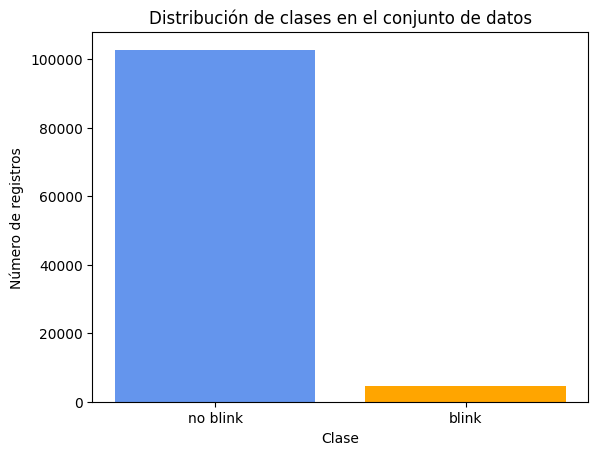

In [85]:
# Contar el número de registros por cada clase
counts = labels['blink'].value_counts()

# Crear un gráfico de barras
plt.bar(["no blink", "blink"], counts.values, color=['cornflowerblue', 'orange'])

# Etiquetar los ejes y agregar un título
plt.xlabel('Clase')
plt.ylabel('Número de registros')
plt.title('Distribución de clases en el conjunto de datos')

# Mostrar la gráfica
plt.show()

### Preparar el conjunto de datos

Dado que no es optimo entrenar, validar y testear nuestro modelo con el mismo conjunto de datos, se debe de subdividir en varios grupos que servirán para las tareas previamente mencionadas.

- **Creamos las tres particiones de datos: entrenamiento, validación y test**

A través del método `train_test_split()` se puede crear particiones en nuestro conjunto de datos. Dichas particiones puedes ser creadas en base a unos parámetros predefinidos como pude ser el procentaje del registros que se adjuntan a un subconjuntos u a otro.

En este caso, se procede a la partición de 3 subconjuntos: entrenamiento, validación y prueba. Del conjunto incial se distribuye un 80% de los registros para el subconjunto de entrenamiento, un 10 % para el conjunto de test otro 10% para el subconjunto de prueba. Cabe destacar que las subdivisiones se han realizado en base la semilla aleartoria `2023`, esto permite reproducir las particiones en otros casos. La semilla aleartoria definida para este pasó será la semilla de referencia para siguientes usos en este trabajo.

Respecto al desbalaceo de los datos, la función `train_test_split()` permite aplicar el método de estratificación para garantizar que las muestras se dividan de manera proporcional y representativa. Esto se especifica mediante el parámetro `stratify` especificando la columna clase del dataset, en este caso la columna "*blink*".

In [86]:
# Semilla para replicar los experimentos
seed = 2023

# Creamos las tres particiones de datos: entrenamiento, validación y test aplicando estratificación
train_data, test_data = train_test_split(labels, test_size=0.2, stratify=labels["blink"], random_state=seed)
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data["blink"], random_state=seed)

En Keras no existen generadores por defecto que devuelvan dos imágenes. Necesitamos crear nuestro propio generador que devuelva a la vez las imágenes de ambos ojos y la etiqueta del frame. Para ello podemos crear dos generadores (uno para cada ojo) usando el método `flow_from_databrame` y combinarlos para crear el generador deseado.

Para abordar el desequilibrio de clases, se hace uso de la técnica de generación de datos artificiales, conocida como "*data augmentation*". La biblioteca Keras proporciona una clase llamada ImageDataGenerator que puedes utilizar para generar imágenes adicionales con ligeras variaciones.

In [87]:
# Aplicar tecnicas de preprocesado
datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=10, # rotación aleatoria en un rango de 20 grados
                             width_shift_range=0.1, # desplazamiento horizontal aleatorio en un rango del 10% de la anchura de la imagen
                             height_shift_range=0.1, # desplazamiento vertical aleatorio en un rango del 10% de la altura de la imagen
                             zoom_range=0.1, # zoom aleatorio en un rango del 10%
                             horizontal_flip=True, # reflejo horizontal aleatorio
)

# Columnas dataset
left_eye_col = 'left_eye'
right_eye_col = 'right_eye'
y_col = 'blink'

# Parámetros
batch_size = 128
img_width = 122 # minimo 75x75
img_height = 75

# Generador custom que devuelve un generador del ojo especificado
def eye_generator(dataframe, eye_col):
  return datagen.flow_from_dataframe(dataframe=dataframe, 
                                                    directory = imgs_path, 
                                                    target_size =(img_width, img_height), 
                                                    x_col=eye_col, 
                                                    y_col=y_col, 
                                                    class_mode="binary", 
                                                    seed=seed, 
                                                    batch_size=batch_size)
  
# Generador custom que devuelve las dos imagenes de ojos y el label del parpadeo
def generator(dataframe):
  left_eye_generator = eye_generator(dataframe, left_eye_col)
  right_eye_generator = eye_generator(dataframe, right_eye_col)
  
  while True:
    left_eye = left_eye_generator.next()
    left_eye_image = left_eye[0]
    label = left_eye[1]
    right_eye = right_eye_generator.next()
    right_eye_image = right_eye[0]
    yield [left_eye_image, right_eye_image], label

def train_generator_func():
  return generator(train_data)

def val_generator_func():
    return generator(val_data)

def test_generator_func():
    return generator(test_data)

# Llamada a la función generator
train_generator = train_generator_func()
val_generator = val_generator_func()
test_generator = test_generator_func()

- **Definición de parámetros comunes**

En el proceso de construcción y prueba de los modelos existen parámetros que se comparten como pueden ser los inputs que recibe el modelo, el ratio de aprendizaje (learning rate) o las metricas de evaluación como la **F1-Score**.

El **F1-Score** es una métrica que combina las métricas de precisión y recall en una sola medida, para evaluar el desempeño de un modelo de clasificación. Es especialmente útil en conjuntos de datos desbalanceados, donde una clase tiene muchas más muestras que las demás, ya que proporciona una medida más robusta del desempeño del modelo que la precisión o el recall por sí solos. 

In [88]:
"""" Configuraciones previas """

# Definimos la métrica F1
f1_score = F1Score(name="f1_score", num_classes=1, threshold=0.5, average='macro')

# Declaramos dos capas de Input
input_shape = (img_width,img_height,3)

input_image1 = Input(shape=input_shape)
input_image2 = Input(shape=input_shape)

# Definimos el ratio de aprendizaje
lr = 1e-4

- **Visualización del entrenamiento**

Puede ser útil poder observar como ha rendido el modelo en la fase de entrenamiento, por ello se crea la función `results_visualization()` que recibe el objeto resultante del entrenamiento y muestra dos gráficas. Estas gráficas representan la evolución de las métricas F1-Score y la perdida del modelo respecto al conjunto de entrenamiento y validación.

In [89]:
def results_visualization(history):
    epochs = [i for i in range(len(history.history['f1_score']))]
    fig, ax = plt.subplots(1, 2) # Create de plots
    train_f1 = history.history['f1_score']
    train_loss = history.history['loss']
    val_f1 = history.history['val_f1_score']
    val_loss = history.history['val_loss']
    fig.set_size_inches(10, 9)
    
    ax[0].plot(epochs, train_f1, 'go-', label='Training F1-Score')
    ax[0].plot(epochs, val_f1, 'ro-', label='Validation F1-Score')
    ax[0].set_title('Training and validation F1-Score')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('F1-Score')
    
    ax[1].plot(epochs, train_loss, 'go-', label='Training loss')
    ax[1].plot(epochs, val_loss, 'ro-', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    
    plt.show()

## InceptionResNetV2 más Transfer Learning

El primer modelo que se contruye esta conformado sobre la base del modelo pre-entrenado **InceptionResNetV2**, disponible a traves de la libreria **keras**. **InceptionResNetV2** tiene un tamaño de 80 MB, ha sido entrenado con 55.9 millones de parámetros y tiene una profuncidad de 449 capas. Respecto a la precisión del mismo, presenta un 95.3% de precisión para el dataset de validación de ImageNet.

- **Definición del modelo**

Antes de entrenar el modelo, es importante decidir qué capas se actualizarán durante el entrenamiento. Para este caso, como se va a hacer uso de **InceptionResNetV2** como extractor de características, se marcan todas las capas del modelo como no entrenables.

Dado que la entrada del modelo son dos imágenes, es necesario realizar algunas modificaciónes respecto a como se implementa el modelo **InceptionResNetV2**. Para este caso, se llama al modelo dos veces extrayendo individualmente las caractaristicas de ambas imágenes. Posteriormente, mediante la función `Concatenate()` se unifican. 

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 122, 75, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_20 (InputLayer)          [(None, 122, 75, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 inception_resnet_v2 (Functiona  (None, 1536)        54336736    ['input_19[0][0]',               
 l)                                                               'input_20[0][0]']         

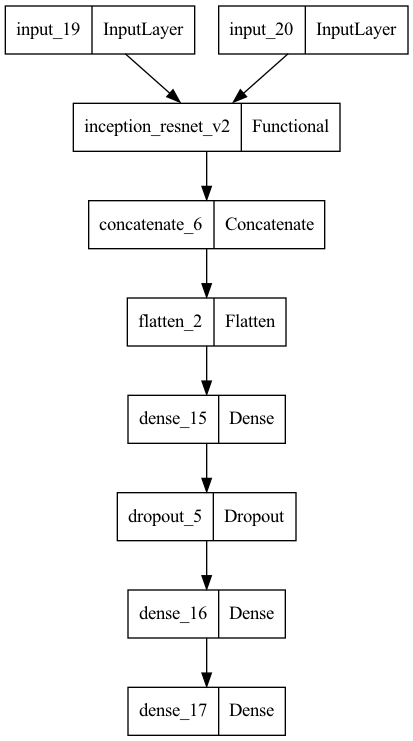

In [90]:
# Cargar InceptionResNetV2 pre-entrenado en ImageNet, sin la capa final
base_model_incept = InceptionResNetV2(weights='imagenet', include_top=False, pooling='avg')

# Congelar todas las capas del modelo base para aplicar transfer learning
for layer in base_model_incept.layers:
    layer.trainable = False

# Extraer las características utilizando InceptionResNetV2
features_image1 = base_model_incept(input_image1)
features_image2 = base_model_incept(input_image2)

# Combinar las características de ambas imágenes
merged_features = Concatenate()([features_image1, features_image2])

# Añadir capas adicionales para la clasificación
x = Flatten()(merged_features)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Crear el modelo
model_incept = Model(inputs=[input_image1, input_image2], outputs=output)

# Compilar el modelo
model_incept.compile(optimizer=optimizers.legacy.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy', f1_score])

# Imprimir un resumen del modelo
model_incept.summary()

# Grafica de la estructura de la red
plot_model(model_incept, to_file='model_incept.png')

- **Entrenar el modelo**

Una vez definido el modelo se procede a ajustarlo . El ajuste o entrenamiento se realiza a traves del método `.fit()`. Toma como entrada los datos de entrenamiento (características y etiquetas), y realiza un ajuste iterativo de los pesos de las capas de la red neuronal con el objetivo de minimizar una función de pérdida. Durante el entrenamiento, el modelo ajusta sus pesos utilziando el algoritmo de optimización especificado en la llamada al método `.compile()`.

Para este caso, se especifica un entrenamiento de 10 epoch (ejecuciones). Cada ejecución se divide en `steps_per_epoch` pasos siendo `steps_per_epoch`:

\begin{align}
        \mathbf{steps\_per\_epoch} = \frac{n\_train\_data}{batch\_size}
\end{align}

Donde `n_train_data` corresponde al número de elementos del subconjunto de entrenamiento y `batch_size` al tamaño del *batch*. Dado que se hace uso de un conjunto de validación durante el entrenamiento, tambien se deben especificar cantos "*pasos*" se realizan por *epoch*. Los `validation_steps` se definen de igual forma que los `steps_per_epoch`, sutituyendo `n_train_data` por el número de elementos del subconjunto de validación.

Dado que el ajuste del modelo puede tomar bastante tiempo, se aplica el método **Early stopping**, una técnica que detiene el proceso de entrenamiento antes de que se produzca un sobreajuste (*overfitting*) en los datos de entrenamiento.

Otra de las medidas tomada para combatir el desbalanceo de la clase 'blink' trata de dar más peso a la clase minoritaria (cuando parapadea). Este ajuste se realiza mediante la función `compute_class_weight()`, esta calcula los pesos de las clases para abordar el problema del desequilibrio de clases en el conjunto de datos. En este caso, se utiliza para el parámetro `class_weight` el método *'balanced'*, lo que significa que los pesos de las clases se calcularán de manera inversamente proporcional a la frecuencia de las clases en los datos de entrenamiento.

In [91]:
# Configuración del método 'Early stopping'
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Steps por epoch
steps_per_epoch = len(train_data) / batch_size
validation_steps = len(val_data) / batch_size

# Calculo del peso de las clases para combatir el desbalanceo
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data[y_col]), y=train_data[y_col])
class_weight_dict = dict(enumerate(class_weights))

# Entrenamos el modelo con los datos preparados en el punto 2
history = model_incept.fit(train_generator,
          epochs=10,  # numero de epochs
          verbose=2,  # muestra informacion del error al finalizar cada epoch
          steps_per_epoch=steps_per_epoch,
          validation_data=val_generator,
          validation_steps=validation_steps,
          callbacks=[early_stopping], # Añadir el callback de 'early stoppoing'
          class_weight=class_weight_dict)

Found 85880 validated image filenames belonging to 2 classes.
Found 85880 validated image filenames belonging to 2 classes.
Epoch 1/10
Found 10735 validated image filenames belonging to 2 classes.
Found 10735 validated image filenames belonging to 2 classes.
670/670 - 351s - loss: 0.2385 - accuracy: 0.8904 - f1_score: 0.4140 - val_loss: 0.1433 - val_accuracy: 0.9369 - val_f1_score: 0.5525 - 351s/epoch - 523ms/step
Epoch 2/10
670/670 - 215s - loss: 0.1697 - accuracy: 0.9257 - f1_score: 0.5183 - val_loss: 0.0882 - val_accuracy: 0.9677 - val_f1_score: 0.7057 - 215s/epoch - 320ms/step
Epoch 3/10
670/670 - 214s - loss: 0.1480 - accuracy: 0.9384 - f1_score: 0.5655 - val_loss: 0.0851 - val_accuracy: 0.9672 - val_f1_score: 0.7042 - 214s/epoch - 319ms/step
Epoch 4/10
670/670 - 230s - loss: 0.1326 - accuracy: 0.9448 - f1_score: 0.5948 - val_loss: 0.1778 - val_accuracy: 0.9265 - val_f1_score: 0.5238 - 230s/epoch - 342ms/step
Epoch 5/10
670/670 - 212s - loss: 0.1283 - accuracy: 0.9472 - f1_score: 

Máximo error:  0.23852652311325073
Mínimo error:  0.10062341392040253


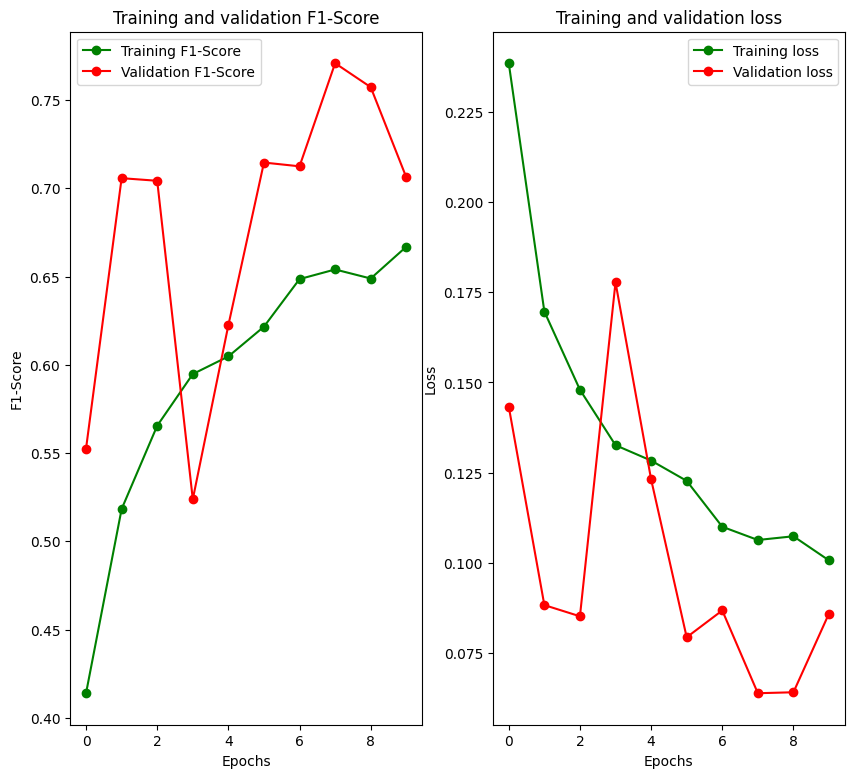

In [92]:
# Visualización de los datos
print("Máximo error: ", max(np.array(history.history["loss"])))
print("Mínimo error: ", min(np.array(history.history["loss"])))
results_visualization(history)

Después del entrenamiento, evalúa el rendimiento del modelo en el conjunto de prueba. Como metrícas de evaluación se toman la perdida del modelo, su precisión y el *F1-Score* obtenido. De forma similar al ajuste del modelo, se subdivide la ejecución en "pasos". Los `steps_eval` (pasos) en los que se va a evaluar el modelo son:

\begin{align}
        \mathbf{steps\_eval} = \frac{n\_test\_data}{batch\_size}
\end{align}

Donde `n_test_data` corresponde al número de elementos del subconjunto de test y `batch_size` al tamaño del *batch*. 

Como se observa en el código, el proceso de evaluación se encapsula en la función `eval_model()` que será usada en el posterior modelo.

In [93]:
def eval_model(model):
  # Pasos de la ejecución
  step_eval = len(test_data) / batch_size

  # Evaluar el modelo en el conjunto de test
  test_loss, test_acc, test_f1_score = model.evaluate(test_generator, steps=step_eval, verbose=1)
  print(f"Test_loss: {test_loss:.4f}, Test_acc: {test_acc:.4f}, Test_F1_Score: {test_f1_score:.4f}")

# Llamada a la función eval model
eval_model(model_incept)

Found 10735 validated image filenames belonging to 2 classes.
Found 10735 validated image filenames belonging to 2 classes.
83/83 [==============================] - 27s 327ms/step - loss: 0.0893 - accuracy: 0.9653 - f1_score: 0.7024
Test_loss: 0.0893, Test_acc: 0.9653, Test_F1_Score: 0.7024


Además de analizar el error obtenido, podemos utilizarlo para hacer predicciones. Para ello utilizaremos el método `predict`, al que le suministremos los datos de entrada.

In [94]:
def predict_model(model):
  # Pasos de la ejecución
  steps_predic = len(test_data) / batch_size
  
  # Obtenemos las predicciones para todos los ejemplos del conjunto de test
  predictions = model.predict(test_generator, batch_size=batch_size, steps=steps_predic, verbose=1)

  # Imprimimos la predicción obtenida para los dos primeros ejemplos
  # Los valores obtenidos representan las probabilidades para cada una de las 5 clases
  for i in range(0,2):
    print("\n Ejemplo", i)
    print("\t Probabilidades para las 2 clases:", predictions[i])
    print()
    print("\t Clase predicha: %i, Probabilidad: %.4f" % (np.argmax([predictions[i]]), np.max(predictions[i])))
    
    
# Llamada a la función eval model
predict_model(model_incept)

83/83 [==============================] - 91s 806ms/step

 Ejemplo 0
	 Probabilidades para las 2 clases: [0.0004477]

	 Clase predicha: 0, Probabilidad: 0.0004

 Ejemplo 1
	 Probabilidades para las 2 clases: [0.00092495]

	 Clase predicha: 0, Probabilidad: 0.0009


## Fine Tuning con DenseNet

El segundo modelo que se propone en este trabajo es una red confomada por un modelo pre-entrenado al que aplicando *fine tunning* se re-entrena una parte del modelo. En la parte final de la red la conforman una serie de capas totalmente conectadas y capas *dropout*.

- **Definición del modelo**

En este caso se hace uso del modelo **DenseNet121**. Este tiene un tamaño de 80 MB, ha sido entrenado con 20.1 millones de parámetros y tiene una profuncidad de 402 capas. Respecto a la precisión del mismo, presenta un 93.6% de precisión para el dataset de validación de ImageNet.

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 122, 75, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_20 (InputLayer)          [(None, 122, 75, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 densenet169 (Functional)       (None, 1664)         12642880    ['input_19[0][0]',               
                                                                  'input_20[0][0]']         

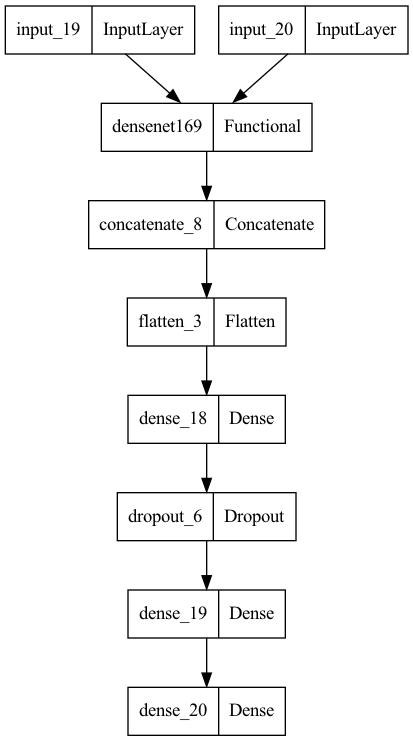

In [96]:
# Cargar el modelo DenseNet121 pre-entrenado en ImageNet sin incluir la capa de salida
base_model_densenet = DenseNet169(weights='imagenet', include_top=False, pooling='avg')

# Congelar todas las capas del modelo base
for layer in base_model_densenet.layers:
    layer.trainable = False

# Descongelar las últimas capas para aplicar fine-tuning
# (en este ejemplo, descongelamos las últimas 50 capas)
for layer in base_model_densenet.layers[-50:]:
    layer.trainable = True

# Extraer las características utilizando InceptionResNetV2
features_image1 = base_model_densenet(input_image1)
features_image2 = base_model_densenet(input_image2)

# Combinar las características de ambas imágenes
merged_features = Concatenate()([features_image1, features_image2])

# Añadir capas adicionales para la clasificación
x = Flatten()(merged_features)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)

# Añadir una capa Dense de salida con una función de activación sigmoide (clasificación binaria)
output = Dense(1, activation='sigmoid')(x)

# Crear el nuevo modelo
model_dn = Model(inputs=[input_image1, input_image2], outputs=output)

# Compilar el modelo con la función de pérdida binary_crossentropy y la métrica de precisión
model_dn.compile(optimizer=optimizers.legacy.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy', f1_score])

# Imprimir un resumen del modelo
model_dn.summary()

# Grafica de la estructura de la red
plot_model(model_dn, to_file='model_dn.png')

- **Entrenar el modelo**

El ajuste del modelo es identico al enfoque desarrollado en el modelo previo. Destacar los aspectos más importantes como son la distribución de pesos por clase, el calculo de "pasos" por *epoch* y la aplicación de *early stopping*.

In [97]:
# Configuración del método 'Early stopping'
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Steps por epoch
steps_per_epoch = len(train_data) / batch_size
validation_steps = len(val_data) / batch_size

# Calculo del peso de las clases para combatir el desbalanceo
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data[y_col]), y=train_data[y_col])
class_weight_dict = dict(enumerate(class_weights))

# Entrenamos el modelo con los datos preparados en el punto 2
history = model_dn.fit(train_generator,
          epochs=10,  # numero de epochs
          verbose=2,  # muestra informacion del error al finalizar cada epoch
          steps_per_epoch=steps_per_epoch,
          validation_data=val_generator,
          validation_steps=validation_steps,
          callbacks=[early_stopping], # Añadsir el callback de 'early stoppoing'
          class_weight=class_weight_dict)

Epoch 1/10
670/670 - 376s - loss: 0.1717 - accuracy: 0.9276 - f1_score: 0.5393 - val_loss: 0.1091 - val_accuracy: 0.9577 - val_f1_score: 0.6555 - 376s/epoch - 560ms/step
Epoch 2/10
670/670 - 246s - loss: 0.0983 - accuracy: 0.9627 - f1_score: 0.6858 - val_loss: 0.0552 - val_accuracy: 0.9783 - val_f1_score: 0.7903 - 246s/epoch - 367ms/step
Epoch 3/10
670/670 - 248s - loss: 0.0730 - accuracy: 0.9712 - f1_score: 0.7421 - val_loss: 0.0592 - val_accuracy: 0.9774 - val_f1_score: 0.7785 - 248s/epoch - 369ms/step
Epoch 4/10
670/670 - 246s - loss: 0.0726 - accuracy: 0.9719 - f1_score: 0.7452 - val_loss: 0.0413 - val_accuracy: 0.9844 - val_f1_score: 0.8432 - 246s/epoch - 366ms/step
Epoch 5/10
670/670 - 246s - loss: 0.0677 - accuracy: 0.9721 - f1_score: 0.7477 - val_loss: 0.0481 - val_accuracy: 0.9825 - val_f1_score: 0.8089 - 246s/epoch - 366ms/step
Epoch 6/10
670/670 - 241s - loss: 0.0629 - accuracy: 0.9744 - f1_score: 0.7663 - val_loss: 0.0349 - val_accuracy: 0.9866 - val_f1_score: 0.8636 - 241s

Máximo error:  0.1717340052127838
Mínimo error:  0.04926537722349167


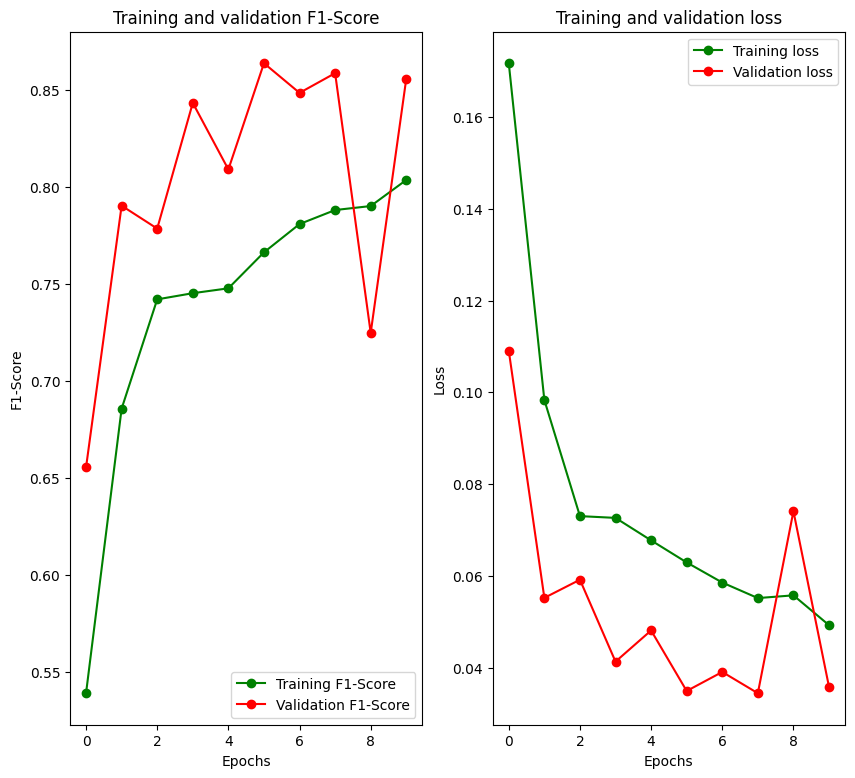

In [98]:
# Visualización de los datos
print("Máximo error: ", max(np.array(history.history["loss"])))
print("Mínimo error: ", min(np.array(history.history["loss"])))
results_visualization(history)

- **Evaluación del modelo**

Seguido del entrenamiento del modelo se evalua el mismo con un conjunto de prueba. Como metrícas de evaluación se toman la perdida del modelo, su precisión y el *F1-Score* obtenido. Al igual que la evaluación del modelo previo se , se subdivide la ejecución en "pasos". Los `steps_eval` (pasos) en los que se va a evaluar el modelo son:

In [99]:
# Por ultimo, podemos evaluar el modelo en el conjunto de test
eval_model(model_dn)

83/83 [==============================] - 29s 352ms/step - loss: 0.0327 - accuracy: 0.9878 - f1_score: 0.8712
Test_loss: 0.0327, Test_acc: 0.9878, Test_F1_Score: 0.8712


Además de analizar el error obtenido, podemos utilizarlo para hacer predicciones. Para ello utilizaremos el método `predict`, al que le suministremos los datos de entrada.

In [100]:
# Obtenemos las predicciones para todos los ejemplos del conjunto de test
predict_model(model_dn)

83/83 [==============================] - 78s 717ms/step

 Ejemplo 0
	 Probabilidades para las 2 clases: [1.5106471e-12]

	 Clase predicha: 0, Probabilidad: 0.0000

 Ejemplo 1
	 Probabilidades para las 2 clases: [1.1898116e-09]

	 Clase predicha: 0, Probabilidad: 0.0000
